In [0]:
import tensorflow as tf
import pandas as pd
import numpy as np
import time

#Visualization tools
from matplotlib import pyplot as plt
import seaborn as sns; sns.set()
import itertools

#ML steps structure
from sklearn.pipeline import FeatureUnion, Pipeline

#Preprocessing
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler
from sklearn.feature_extraction.text import HashingVectorizer, CountVectorizer
from sklearn.base import TransformerMixin
from imblearn.under_sampling import RandomUnderSampler

#Dimensionality reduction
from sklearn.decomposition import TruncatedSVD

#Model Validation
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, silhouette_score, davies_bouldin_score
from sklearn.metrics.cluster import adjusted_rand_score

#Model selected
from sklearn.cluster import KMeans #KMeans
from sklearn.mixture import GaussianMixture #EM

In [0]:
#Read the data using the Unnamed (probably id) as index
url = 'https://s3.amazonaws.com/drivendata/data/4/public/81e8f2de-9915-4934-b9ae-9705685c9d50.csv'
training = pd.read_csv(url, index_col='Unnamed: 0')

labels = ['Function', 'Object_Type', 'Operating_Status', 'Position_Type', 'Pre_K', 'Reporting', 
          'Sharing', 'Student_Type', 'Use']

numeric = ['FTE', 'Total']

categoric = [ 'Facility_or_Department', 'Function_Description', 
            'Fund_Description', 'Job_Title_Description', 'Location_Description', 
            'Object_Description', 'Position_Extra', 'Program_Description', 'SubFund_Description', 
            'Sub_Object_Description', 
            'Text_1', 'Text_2', 'Text_3', 'Text_4']

## Pre-Processing

In [0]:
#Imputing data in Total column
def impute_func_total(data):
    if(pd.isnull(data['Total'])):        
        if(data['Object_Type'] == 'Base Salary/Compensation'):
            return 24146
        if(data['Object_Type'] == 'Benefits'):
            return 38163
        if(data['Object_Type'] == 'Contracted Services'):
            return 24146
        if(data['Object_Type'] == 'Equipment & Equipment Lease'):
            return 11257
        if(data['Object_Type'] == 'NO_LABEL'):
            return 58545
        if(data['Object_Type'] == 'Other Compensation/Stipend'):
            return 1605
        if(data['Object_Type'] == 'Other Non-Compensation'):
            return 10646
        if(data['Object_Type'] == 'Rent/Utilities'):
            return 46611
        if(data['Object_Type'] == 'Substitute Compensation'):
            return 1090
        if(data['Object_Type'] == 'Supplies/Materials'):
            return 7745
        if(data['Object_Type'] == 'Travel & Conferences'):
            return 1659
    else:
        return data['Total']

In [0]:
#Imputing data in FTE column
def impute_func_FTE(data):
    if(pd.isnull(data['FTE'])):        
        if(data['Object_Type'] == 'Base Salary/Compensation'):
            return 0.45
        if(data['Object_Type'] == 'Benefits'):
            return 0.0
        if(data['Object_Type'] == 'Contracted Services'):
            return 0.0
        if(data['Object_Type'] == 'Equipment & Equipment Lease'):
            return 0.0
        if(data['Object_Type'] == 'NO_LABEL'):
            return 0.75
        if(data['Object_Type'] == 'Other Compensation/Stipend'):
            return 0.000107
        if(data['Object_Type'] == 'Other Non-Compensation'):
            return 0.0
        if(data['Object_Type'] == 'Rent/Utilities'):
            return 0.0
        if(data['Object_Type'] == 'Substitute Compensation'):
            return 0.000059
        if(data['Object_Type'] == 'Supplies/Materials'):
            return 0.0
        if(data['Object_Type'] == 'Travel & Conferences'):
            return 0.0
    else:
        return data['FTE']

In [0]:
def preProcessing(training):
    # Remove inconsistent data
    training.loc[(training['FTE'] < 0) | (training['FTE'] > 1), 'FTE'] = np.nan
    training.loc[training['Total'] < 0, 'Total'] = np.nan
    
    training['Total'] = training.apply(impute_func_total, axis = 1)
    
    training['FTE'] = training.apply(impute_func_FTE, axis = 1)
    
    for category in categoric:
        training[category] = training[category].str.lower()
    
    training[categoric] = training[categoric].fillna("")
    
    return training

In [0]:
df_training = preProcessing(training)
df_training = df_training.reset_index(drop = True)

In [0]:
DataSet = df_training.drop(columns=labels)
labels_data = pd.get_dummies(df_training['Object_Type'])

In [0]:
col_names = list(range(0,11))
labels_data.columns = col_names
labels_data = labels_data.idxmax(axis=1)

In [0]:
labels_data.values

array([4, 4, 0, ..., 4, 1, 8])

## Pipeline

In [0]:
def combine_text_columns(dataset):
    return dataset[categoric].apply(lambda x: " ".join(x), axis = 1)

get_text_data = FunctionTransformer(combine_text_columns, validate = False)

In [0]:
def combine_numeric_columns(dataset):
    return dataset[numeric]

get_numeric_data = FunctionTransformer(combine_numeric_columns, validate = False)

In [0]:
pl = Pipeline([
        ('union', FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([
                    ('selector', get_numeric_data),
                ])),
                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    ('vectorizer',HashingVectorizer(token_pattern="[A-Za-z0-9]+(?=\\s+)", 
                                                    norm=None, 
                                                    binary=False,
                                                    ngram_range=(1,2), stop_words = 'english') 
                    )
                ]))
             ]
        )),
        ('reduce_dim', TruncatedSVD(n_components = 100)),             
    ])

In [0]:
sdv_data = pl.fit_transform(DataSet, labels_data)

In [0]:
rus = RandomUnderSampler()
DS_resampled, labels_resampled = rus.fit_resample(sdv_data, labels_data)

## KMeans


In [0]:
#kmeans = KMeans(n_clusters=2, random_state=10)

In [0]:
#cluster_labels = kmeans.fit_predict(DS_resampled)

In [0]:
#slt_score = silhouette_score(DS_resampled, cluster_labels, metric='euclidean')

In [0]:
k_values = []
silhouette_scores = []
db_scores = []
cr_scores = []

seeds = [10, 20, 40, 80, 120]

for k in range(2, 21):
  
  silhouette_avg = []
  db_avg = []
  cr_avg = []
  
  for seed in seeds:
    kmeans = KMeans(n_clusters= k, random_state=seed)

    #fit model to data
    cluster_labels = kmeans.fit_predict(DS_resampled)

    slt_score = silhouette_score(DS_resampled, cluster_labels)
    silhouette_avg.append(slt_score)
    
    db_score = davies_bouldin_score(DS_resampled, cluster_labels)
    db_avg.append(db_score)
    
    cr_score = adjusted_rand_score(labels_resampled, cluster_labels)
    cr_avg.append(cr_score) 
  
  #Set metrics values
  print("For n_clusters = {}, The average silhouette_score is : {}".format(k, np.mean(silhouette_avg)))
  print("For n_clusters = {}, The average db_score is : {}".format(k, np.mean(db_avg)))
  print("For n_clusters = {}, The average cr_score is : {}".format(k, np.mean(cr_avg)))
    
  # Append the results
  k_values.append(k)
  silhouette_scores.append(np.mean(silhouette_avg))
  db_scores.append(np.mean(db_avg))
  cr_scores.append(np.mean(cr_avg))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_d

For n_clusters = 2, The average silhouette_score is : 0.9974111158400639
For n_clusters = 2, The average db_score is : 0.4183019049162316
For n_clusters = 2, The average cr_score is : 9.12536722348962e-08


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_d

For n_clusters = 3, The average silhouette_score is : 0.9946912478456513
For n_clusters = 3, The average db_score is : 0.39416820548921266
For n_clusters = 3, The average cr_score is : 4.5567998739459916e-07


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_d

For n_clusters = 4, The average silhouette_score is : 0.9914399414433367
For n_clusters = 4, The average db_score is : 0.40737074133854206
For n_clusters = 4, The average cr_score is : 7.246455638986779e-07


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_d

For n_clusters = 5, The average silhouette_score is : 0.991455035349081
For n_clusters = 5, The average db_score is : 0.39885275364504336
For n_clusters = 5, The average cr_score is : 7.230477019679999e-07


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_d

For n_clusters = 6, The average silhouette_score is : 0.9691743203652023
For n_clusters = 6, The average db_score is : 0.41569263445613813
For n_clusters = 6, The average cr_score is : 8.628738470632134e-06


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_d

For n_clusters = 7, The average silhouette_score is : 0.8718577883879226
For n_clusters = 7, The average db_score is : 0.4532027127324632
For n_clusters = 7, The average cr_score is : 0.008186298910435541


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_d

For n_clusters = 8, The average silhouette_score is : 0.84843634275819
For n_clusters = 8, The average db_score is : 0.41995242177600833
For n_clusters = 8, The average cr_score is : 0.010450091103749738


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_d

For n_clusters = 9, The average silhouette_score is : 0.8490128828499219
For n_clusters = 9, The average db_score is : 0.43891918909779315
For n_clusters = 9, The average cr_score is : 0.01110801383420681


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_di

For n_clusters = 10, The average silhouette_score is : 0.8514379610701444
For n_clusters = 10, The average db_score is : 0.4064039067524208
For n_clusters = 10, The average cr_score is : 0.01173108403095618


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dis

For n_clusters = 11, The average silhouette_score is : 0.85440768014325
For n_clusters = 11, The average db_score is : 0.37448943610833807
For n_clusters = 11, The average cr_score is : 0.012150646169559406


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dis

For n_clusters = 12, The average silhouette_score is : 0.8543762128604625
For n_clusters = 12, The average db_score is : 0.34109809526694057
For n_clusters = 12, The average cr_score is : 0.012141225208881863


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dis

For n_clusters = 13, The average silhouette_score is : 0.8544412377569017
For n_clusters = 13, The average db_score is : 0.32687080973286997
For n_clusters = 13, The average cr_score is : 0.012150607763951635


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dis

For n_clusters = 14, The average silhouette_score is : 0.8550154223279817
For n_clusters = 14, The average db_score is : 0.33263710473480584
For n_clusters = 14, The average cr_score is : 0.012232618829302119


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dis

For n_clusters = 15, The average silhouette_score is : 0.8507868235967662
For n_clusters = 15, The average db_score is : 0.34683051888509986
For n_clusters = 15, The average cr_score is : 0.012720788446811182


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dis

For n_clusters = 16, The average silhouette_score is : 0.8507637843622048
For n_clusters = 16, The average db_score is : 0.3465662878010938
For n_clusters = 16, The average cr_score is : 0.012721777458675462


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dis

For n_clusters = 17, The average silhouette_score is : 0.8321698769077777
For n_clusters = 17, The average db_score is : 0.3533354579347715
For n_clusters = 17, The average cr_score is : 0.015446514345845142


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dis

For n_clusters = 18, The average silhouette_score is : 0.8319497069314961
For n_clusters = 18, The average db_score is : 0.3198474106380105
For n_clusters = 18, The average cr_score is : 0.015440183591270192


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dis

For n_clusters = 19, The average silhouette_score is : 0.8291824378654284
For n_clusters = 19, The average db_score is : 0.31474885559890253
For n_clusters = 19, The average cr_score is : 0.01582508963646826


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dis

For n_clusters = 20, The average silhouette_score is : 0.8295166327969804
For n_clusters = 20, The average db_score is : 0.3308141197560383
For n_clusters = 20, The average cr_score is : 0.01574497059914344


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


In [0]:
len(k_values)

19

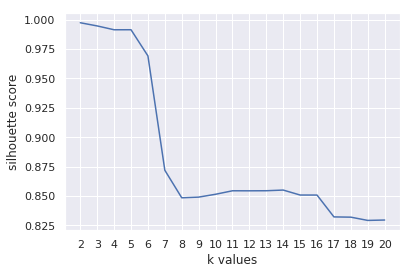

In [0]:
plt.plot(k_values, silhouette_scores)
#plt.axis([2, 21, 0.8, 1])
plt.xticks(np.arange(2, 21, step=1))
plt.xlabel("k values")
plt.ylabel("silhouette score")
plt.show()

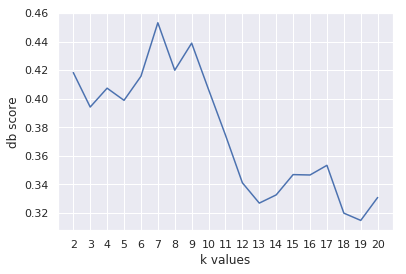

In [0]:
plt.plot(k_values, db_scores)
#plt.axis([2, 21, 0.8, 1])
plt.xticks(np.arange(2, 21, step=1))
plt.xlabel("k values")
plt.ylabel("db score")
plt.show()

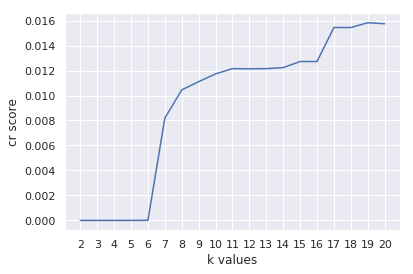

In [0]:
plt.plot(k_values, cr_scores)
#plt.axis([2, 21, 0.8, 1])
plt.xticks(np.arange(2, 21, step=1))
plt.xlabel("k values")
plt.ylabel("cr score")
plt.show()

## Expectation Maximization

In [0]:
gmm = GaussianMixture(n_components=-1, covariance_type='full')

In [0]:
cluster_labels = gmm.fit_predict(DS_resampled)

ValueError: ignored

In [0]:
em_values = []
silhouette_scores = []
db_scores = []
cr_scores = []

seeds = [10, 20, 40, 80, 120]

for k in range(2, 21):
  
  silhouette_avg = []
  db_avg = []
  cr_avg = []
  
  for seed in seeds:
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state = seed)

    #fit model to data
    cluster_labels = gmm.fit_predict(DS_resampled)

    slt_score = silhouette_score(DS_resampled, cluster_labels)
    silhouette_avg.append(slt_score)
    
    db_score = davies_bouldin_score(DS_resampled, cluster_labels)
    db_avg.append(db_score)
    
    cr_score = adjusted_rand_score(labels_resampled, cluster_labels)
    cr_avg.append(cr_score) 
  
  #Set metrics values
  print("For n_clusters = {}, The average silhouette_score is : {}".format(k, np.mean(silhouette_avg)))
  print("For n_clusters = {}, The average db_score is : {}".format(k, np.mean(db_avg)))
  print("For n_clusters = {}, The average cr_score is : {}".format(k, np.mean(cr_avg)))
    
  # Append the results
  em_values.append(k)
  silhouette_scores.append(np.mean(silhouette_avg))
  db_scores.append(np.mean(db_avg))
  cr_scores.append(np.mean(cr_avg))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_d

For n_clusters = 2, The average silhouette_score is : 0.9849022516812911
For n_clusters = 2, The average db_score is : 1.3421527843150296
For n_clusters = 2, The average cr_score is : 5.973603134437087e-06


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_d

For n_clusters = 3, The average silhouette_score is : 0.9825742935251764
For n_clusters = 3, The average db_score is : 1.4018222420213822
For n_clusters = 3, The average cr_score is : 7.373124839802447e-06


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_d

For n_clusters = 4, The average silhouette_score is : 0.9736228641744417
For n_clusters = 4, The average db_score is : 0.7814179795575654
For n_clusters = 4, The average cr_score is : 8.428595916410969e-06


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_d

For n_clusters = 5, The average silhouette_score is : 0.6739302242087548
For n_clusters = 5, The average db_score is : 1.1954426663912758
For n_clusters = 5, The average cr_score is : 0.0019520205301011492


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_di

For n_clusters = 6, The average silhouette_score is : 0.43543313746066187
For n_clusters = 6, The average db_score is : 1.2746704341282677
For n_clusters = 6, The average cr_score is : 0.01638247528446734


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dis

For n_clusters = 7, The average silhouette_score is : 0.3582935171246139
For n_clusters = 7, The average db_score is : 1.2196934580555576
For n_clusters = 7, The average cr_score is : 0.022273934312620598


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_di

For n_clusters = 8, The average silhouette_score is : 0.2106735205705117
For n_clusters = 8, The average db_score is : 1.2124060035284596
For n_clusters = 8, The average cr_score is : 0.03290524165282068


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dis

For n_clusters = 9, The average silhouette_score is : 0.202322295384679
For n_clusters = 9, The average db_score is : 1.8746224912919032
For n_clusters = 9, The average cr_score is : 0.03419659754155022


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dis

For n_clusters = 10, The average silhouette_score is : 0.18804529925049798
For n_clusters = 10, The average db_score is : 3.0755064691265503
For n_clusters = 10, The average cr_score is : 0.03809521798547753


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dis

For n_clusters = 11, The average silhouette_score is : 0.18805820578040527
For n_clusters = 11, The average db_score is : 5.801631266085382
For n_clusters = 11, The average cr_score is : 0.04299330630330141


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dis

For n_clusters = 12, The average silhouette_score is : 0.18424019496437347
For n_clusters = 12, The average db_score is : 6.084868853639337
For n_clusters = 12, The average cr_score is : 0.04630060907179969


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dis

For n_clusters = 13, The average silhouette_score is : 0.16647845504759246
For n_clusters = 13, The average db_score is : 11.874347709498766
For n_clusters = 13, The average cr_score is : 0.046449011224702255


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dis

For n_clusters = 14, The average silhouette_score is : 0.1050209212621259
For n_clusters = 14, The average db_score is : 9.418308005590422
For n_clusters = 14, The average cr_score is : 0.05190648930923787


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dis

For n_clusters = 15, The average silhouette_score is : 0.07219399683687135
For n_clusters = 15, The average db_score is : 3.914691098424277
For n_clusters = 15, The average cr_score is : 0.05358496550707963


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dis

For n_clusters = 16, The average silhouette_score is : -0.012256106452318635
For n_clusters = 16, The average db_score is : 10.557661197023448
For n_clusters = 16, The average cr_score is : 0.066980083435642


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dis

For n_clusters = 17, The average silhouette_score is : -0.03978483007826766
For n_clusters = 17, The average db_score is : 9.547076458488373
For n_clusters = 17, The average cr_score is : 0.07180562254464226


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dis

For n_clusters = 18, The average silhouette_score is : -0.08879606185660067
For n_clusters = 18, The average db_score is : 13.233643565961254
For n_clusters = 18, The average cr_score is : 0.08423553695490071


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dis

For n_clusters = 19, The average silhouette_score is : -0.10400801386064581
For n_clusters = 19, The average db_score is : 11.71787945803024
For n_clusters = 19, The average cr_score is : 0.0903617863721132


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dis

For n_clusters = 20, The average silhouette_score is : -0.09651404041223363
For n_clusters = 20, The average db_score is : 9.146120678428456
For n_clusters = 20, The average cr_score is : 0.0877937738360216


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: invalid value encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


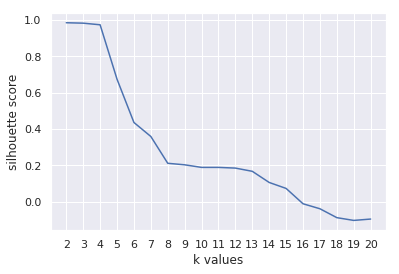

In [0]:
plt.plot(em_values, silhouette_scores)
#plt.axis([2, 21, 0.8, 1])
plt.xticks(np.arange(2, 21, step=1))
plt.xlabel("k values")
plt.ylabel("silhouette score")
plt.show()

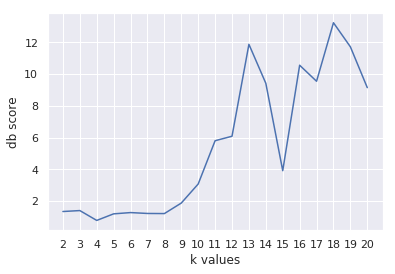

In [0]:
plt.plot(em_values, db_scores)
#plt.axis([2, 21, 0.8, 1])
plt.xticks(np.arange(2, 21, step=1))
plt.xlabel("k values")
plt.ylabel("db score")
plt.show()

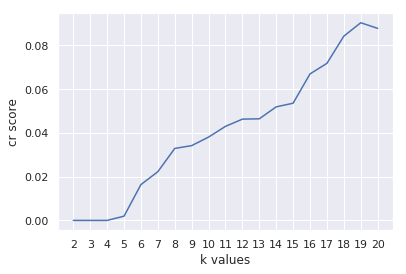

In [0]:
plt.plot(em_values, cr_scores)
#plt.axis([2, 21, 0.8, 1])
plt.xticks(np.arange(2, 21, step=1))
plt.xlabel("k values")
plt.ylabel("cr score")
plt.show()

### KMeans: K = 2, Seed = 10

In [0]:
print("Silhouette Coefficient (k = 2, seed = 10): %0.3f" 
      % silhouette_score(DS_resampled, cluster_labels, metric='euclidean'))
  

TypeError: ignored

In [0]:
print("Davies Bouldin Coefficient (k = 2, seed = 10): %0.3f"
      % davies_bouldin_score(DS_resampled, cluster_labels))


Davies Bouldin Coefficient (k = 2, seed = 10): 0.361


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


In [0]:
unique, counts = np.unique(kmeans.labels_, return_counts=True)
dict(zip(unique, counts))

{0: 275629, 1: 124648}

In [0]:
#https://www.dropbox.com/sh/fhkqy2wybxjl0n5/AAABevgbnnM4HSdPgeUU6tgPa?dl=0

In [0]:
start = time.time()

print("Silhouette Coefficient (k = 2, seed = 10): %0.3f"
      % silhouette_score(sdv_data, cluster_labels, metric='euclidean'))

end = time.time()

Silhouette Coefficient (k = 2, seed = 10): 0.325


In [0]:
end - start

2507.3639125823975

In [0]:
print(__doc__)

from time import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

np.random.seed(42)

digits = load_digits()
data = scale(digits.data)

n_samples, n_features = data.shape
n_digits = len(np.unique(digits.target))
labels = digits.target

sample_size = 300

print("n_digits: %d, \t n_samples %d, \t n_features %d"
      % (n_digits, n_samples, n_features))


print(82 * '_')
print('init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette')


def bench_k_means(estimator, name, data):
    t0 = time()
    estimator.fit(data)
    print(estimator.labels_)
    print('%-9s\t%.2fs\t%i\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
          % (name, (time() - t0), estimator.inertia_,
             metrics.homogeneity_score(labels, estimator.labels_),
             metrics.completeness_score(labels, estimator.labels_),
             metrics.v_measure_score(labels, estimator.labels_),
             metrics.adjusted_rand_score(labels, estimator.labels_),
             metrics.adjusted_mutual_info_score(labels,  estimator.labels_,
                                                average_method='arithmetic'),
             metrics.silhouette_score(data, estimator.labels_,
                                      metric='euclidean',
                                      sample_size=sample_size)))

bench_k_means(KMeans(init='k-means++', n_clusters=2, n_init=10),
              name="k-means++", data=data)

bench_k_means(KMeans(init='random', n_clusters=2, n_init=10),
              name="random", data=data)

# in this case the seeding of the centers is deterministic, hence we run the
# kmeans algorithm only once with n_init=1
pca = PCA(n_components=n_digits).fit(data)
bench_k_means(KMeans(init=pca.components_, n_clusters=10, n_init=1),
              name="PCA-based",
              data=data)
print(82 * '_')

# #############################################################################
# Visualize the results on PCA-reduced data
'''
reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()'''

Automatically created module for IPython interactive environment
n_digits: 10, 	 n_samples 1797, 	 n_features 64
__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
[0 1 0 ... 0 0 1]
k-means++	0.14s	100431	0.176	0.604	0.273	0.123	0.272	0.100
[0 1 0 ... 0 0 1]
random   	0.12s	100429	0.180	0.619	0.279	0.125	0.278	0.105
[3 2 2 ... 2 9 9]
PCA-based	0.04s	70768	0.667	0.694	0.681	0.557	0.677	0.134
__________________________________________________________________________________


"\nreduced_data = PCA(n_components=2).fit_transform(data)\nkmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=10)\nkmeans.fit(reduced_data)\n\n# Step size of the mesh. Decrease to increase the quality of the VQ.\nh = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].\n\n# Plot the decision boundary. For that, we will assign a color to each\nx_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1\ny_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1\nxx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))\n\n# Obtain labels for each point in mesh. Use last trained model.\nZ = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])\n\n# Put the result into a color plot\nZ = Z.reshape(xx.shape)\nplt.figure(1)\nplt.clf()\nplt.imshow(Z, interpolation='nearest',\n           extent=(xx.min(), xx.max(), yy.min(), yy.max()),\n           cmap=plt.cm.Paired,\n           aspect='auto', origin='lower')\n\nplt.plot(reduced_data[:, 

In [0]:
labels

array([0, 1, 2, ..., 8, 9, 8])